In [1]:
import numpy as np
import cv2 as cv
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import time
%matplotlib inline

In [2]:
def get_laplacian_filter(img):
    img = cv.bilateralFilter(img,9,60,60)
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    dst = cv.Laplacian(img, cv.CV_16S, ksize= 3)
    abs_dst = cv.convertScaleAbs(dst)
    
    kernel = np.ones(shape=(3,3))
    abs_dst = cv.dilate(abs_dst,kernel)

    return abs_dst

In [3]:
def process_img(img):
    img = cv.bilateralFilter(img,9+7,75+7,75+7)
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    
    dst = cv.Laplacian(img, cv.CV_16S, ksize=5)
    abs_dst = cv.convertScaleAbs(dst)
    
    kernel = np.ones(shape=(3,3))
    abs_dst = cv.dilate(abs_dst,kernel)
    abs_dst = cv.medianBlur(abs_dst,7)

    return abs_dst

In [4]:
def sobel_filter(img):
    img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img = cv.GaussianBlur(img,(3,3),0)
    sobelx = cv.Sobel(img,cv.CV_64F,1,0,ksize=5)
    sobely = cv.Sobel(img,cv.CV_64F,0,1,ksize=5)
    sobel = sobelx+sobely
    
    return sobel

In [6]:
pastas = sorted(os.listdir("dataset"))
pastas.remove("None")

template = [0 for i in range(len(pastas))]
dic = {}

for i,item in enumerate(pastas):
    copy = template.copy()
    copy[i] = 1
    
    dic[item] = copy
print(dic)

{'A': [1, 0, 0, 0, 0, 0], 'B': [0, 1, 0, 0, 0, 0], 'C': [0, 0, 1, 0, 0, 0], 'D': [0, 0, 0, 1, 0, 0], 'E': [0, 0, 0, 0, 1, 0], 'F': [0, 0, 0, 0, 0, 1]}


In [7]:
dataset = []
classes = []

for pasta in pastas:
    for file in os.listdir("dataset/"+pasta):
        img = cv.imread("dataset/"+pasta+"/"+file)
        
        laplacian = process_img(img).reshape(img.shape[0],img.shape[1],1)
        #sobel = sobel_filter(img).reshape(img.shape[0],img.shape[1],1)
        
        dataset.append(laplacian)
        classes.append(dic[pasta])

dataset = np.array(dataset)
classes = np.array(classes)

print(dataset.shape,classes.shape)

(4475, 250, 150, 1) (4475, 6)


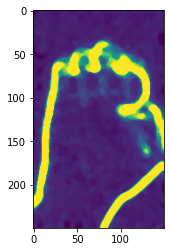

In [8]:
plt.imshow(dataset[3200])

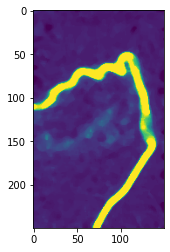

In [9]:
plt.imshow(dataset[100])

In [10]:
SHAPE_CNN = dataset[0].shape
OUTPUT_SHAPE = len(classes[0])
LR = 0.00092
print(SHAPE_CNN,OUTPUT_SHAPE)

(250, 150, 1) 6


In [11]:
def feature_extractor(inputs):
    x = tf.keras.layers.Conv2D(8,kernel_size=3,activation='relu',input_shape=(250,150,1),padding='same')(inputs)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    
    x = tf.keras.layers.Conv2D(16,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    
    x = tf.keras.layers.Conv2D(32,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    
    x = tf.keras.layers.Conv2D(64,kernel_size=3,activation='relu',padding='same')(x)
    x = tf.keras.layers.MaxPool2D((2,2))(x)
    
    return x

In [12]:
def hidden_layers(inputs):
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(16,activation='relu')(x)
    x = tf.keras.layers.Dense(32,activation='relu')(x)
    x = tf.keras.layers.Dense(32,activation='relu')(x)
    
    return x

In [13]:
def classifier(inputs):
    classification = tf.keras.layers.Dense(OUTPUT_SHAPE,activation='sigmoid',name='classification')(inputs)
    
    return classification

In [14]:
def final_model(inputs):
    cnn_layer = feature_extractor(inputs)
    dense_layers = hidden_layers(cnn_layer)
    classification_layer = classifier(dense_layers)
    
    model = tf.keras.Model(inputs=inputs, outputs=[classification_layer])
    return model

In [15]:
def define_and_compile_model(inputs):
    from tensorflow.keras.optimizers import SGD
    
    model = final_model(inputs)
    model.compile(
        optimizer=SGD(learning_rate=LR),
        loss={"classification":"binary_crossentropy"},
        metrics={"classification":"accuracy"}
    )
    return model

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(dataset, classes, test_size=0.3)
print(X_train.shape,X_test.shape)

(3132, 250, 150, 1) (1343, 250, 150, 1)


In [17]:
inputs = tf.keras.layers.Input(shape=(SHAPE_CNN[0],SHAPE_CNN[1],1))
model = define_and_compile_model(inputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250, 150, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 250, 150, 8)       80        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 125, 75, 8)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 75, 16)       1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 37, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 62, 37, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 31, 18, 32)        0     

In [18]:
init = time.time()

model.fit(X_train, y_train, epochs=25, verbose=1)

end = time.time()
print("Ended in",(end-init)/60)

Epoch 1/25
98/98 [==============================] - 47s 467ms/step - loss: 0.6883 - accuracy: 0.2483
Epoch 2/25
98/98 [==============================] - 46s 470ms/step - loss: 0.3417 - accuracy: 0.5637
Epoch 3/25
98/98 [==============================] - 45s 458ms/step - loss: 0.2509 - accuracy: 0.7477
Epoch 4/25
98/98 [==============================] - 44s 451ms/step - loss: 0.1928 - accuracy: 0.8203
Epoch 5/25
98/98 [==============================] - 45s 455ms/step - loss: 0.1619 - accuracy: 0.8613
Epoch 6/25
98/98 [==============================] - 46s 469ms/step - loss: 0.1319 - accuracy: 0.8919
Epoch 7/25
98/98 [==============================] - 44s 448ms/step - loss: 0.1062 - accuracy: 0.9189
Epoch 8/25
98/98 [==============================] - 45s 462ms/step - loss: 0.0953 - accuracy: 0.9303
Epoch 9/25
98/98 [==============================] - 44s 451ms/step - loss: 0.0754 - accuracy: 0.9483
Epoch 10/25
98/98 [==============================] - 46s 473ms/step - loss: 0.0708 - accura

In [19]:
# Laplacian
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

predictions = model.predict(X_test)
predictions = [np.argmax(item) for item in predictions]
for i in range(len(predictions)):
    temp = [0,0,0,0,0,0]
    temp[predictions[i]] += 1
    predictions[i] = temp

print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       249
           1       0.97      1.00      0.99       269
           2       0.99      1.00      1.00       176
           3       1.00      0.99      0.99       211
           4       0.98      0.98      0.98       235
           5       0.99      0.98      0.98       203

   micro avg       0.99      0.99      0.99      1343
   macro avg       0.99      0.99      0.99      1343
weighted avg       0.99      0.99      0.99      1343
 samples avg       0.99      0.99      0.99      1343

0.9888309754281459


In [144]:
# Sobel
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

predictions = model.predict(X_test)
predictions = [np.argmax(item) for item in predictions]
for i in range(len(predictions)):
    temp = [0,0,0,0,0,0]
    temp[predictions[i]] += 1
    predictions[i] = temp

print(classification_report(y_test,predictions))
print(accuracy_score(y_test,predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       240
           1       0.98      0.95      0.96       292
           2       0.99      0.99      0.99       199
           3       0.98      0.98      0.98       184
           4       0.84      0.97      0.90       229
           5       0.98      0.84      0.91       199

   micro avg       0.96      0.96      0.96      1343
   macro avg       0.96      0.96      0.96      1343
weighted avg       0.96      0.96      0.96      1343
 samples avg       0.96      0.96      0.96      1343

0.9560685033507074


In [82]:
model.save("Models/model_8.h5")